[RESOURCE 1](https://www.kaggle.com/rajkumarl/jane-day-242-feature-generation-and-selection/comments)

[RESOURCE 2](https://www.kaggle.com/rajkumarl/jane-tf-keras-lstm)



## Start

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [ ]:
#changing the working directory
%mkdir /content/gdrive/My_Drive/kaggle/janestreet
%cd /content/gdrive/My Drive/kaggle/janestreet

mkdir: cannot create directory ‘/content/gdrive/My_Drive/kaggle/janestreet’: No such file or directory
/content/gdrive/My Drive/kaggle/janestreet


In [ ]:
!kaggle competitions download -c jane-street-market-prediction

competition.cpython-37m-x86_64-linux-gnu.so: Skipping, found more recently modified local copy (use --force to force download)
__init__.py: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
features.csv: Skipping, found more recently modified local copy (use --force to force download)
example_test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
example_sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


## system requirements

In [ ]:
import sys
print('Python\t\ttested on 3.6.3,3.6.5\t\tcurrent:',sys.version)
import numpy
print('numpy\t\ttested on 1.14.3,1.14.5\t\tcurrent:',numpy.__version__)
import pandas
print('pandas\t\ttested on 0.22.0,0.23.0\t\tcurrent:',pandas.__version__)
import matplotlib
print('matplotlib\ttested on 2.2.1,2.2.2\t\tcurrent:',matplotlib.__version__)
import sklearn
print('sklearn\t\ttested on 0.19.1,0.19.2\t\tcurrent:',sklearn.__version__)
import tensorflow
print('tensorflow\ttested on 1.10.0,1.10.1\t\tcurrent:',tensorflow.__version__)
import logging
print('logging\t\ttested on 0.5.1.2\t\tcurrent:',logging.__version__)

Python		tested on 3.6.3,3.6.5		current: 3.7.10 (default, Feb 20 2021, 21:17:23) 
[GCC 7.5.0]
numpy		tested on 1.14.3,1.14.5		current: 1.19.5
pandas		tested on 0.22.0,0.23.0		current: 1.1.5
matplotlib	tested on 2.2.1,2.2.2		current: 3.2.2
sklearn		tested on 0.19.1,0.19.2		current: 0.22.2.post1
tensorflow	tested on 1.10.0,1.10.1		current: 2.4.1
logging		tested on 0.5.1.2		current: 0.5.1.2


## Exploratory data analysis

In [ ]:
!pip -q install datatable shap

import numpy as np
import pandas as pd
import datatable
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn import tree
import missingno as msno
import shap
import gc
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

SEED = 123
np.random.seed(SEED)

     |████████████████████████████████| 83.9MB 35kB/s 
     |████████████████████████████████| 358kB 53.0MB/s 


In [ ]:
#how many rows
!wc -l train.csv.zip


10016591 train.csv.zip


In [ ]:
paths = ["example_sample_submission.csv", "example_test.csv.zip", "train.csv.zip", "features.csv"]
alldata = []
for p in paths:
    alldata.append(datatable.fread(p).to_pandas())

In [ ]:
alldata[0].head(5)

,ts_id,action
0,0,True
1,1,True
2,2,True
3,3,True
4,4,True


In [ ]:
alldata[1].head(5)

,weight,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,...,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,date,ts_id
0,0.000000,1,-1.872746,-2.191242,-0.474163,-0.323046,0.014688,-0.002484,NaN,NaN,-0.989982,-1.055090,NaN,NaN,-2.667671,-2.001475,-1.703595,-2.196892,NaN,NaN,1.483295,1.307466,NaN,NaN,1.175200,0.967805,1.608410,1.319365,NaN,NaN,-0.515073,-0.448988,NaN,NaN,-2.429812,-2.206423,-3.593120,-2.868358,0.112697,0.053157,...,NaN,3.754522,7.137163,-1.863069,NaN,0.434466,NaN,-0.292035,0.317003,-2.605820,NaN,2.896986,NaN,1.485813,4.147254,-2.238831,NaN,-0.892724,NaN,-0.156332,0.622816,-3.921523,NaN,2.561593,NaN,3.457757,6.649580,-1.472686,NaN,NaN,1.168391,8.313583,1.782433,14.018213,2.653056,12.600292,2.301488,11.445807,0,0
1,16.673515,-1,-1.349537,-1.704709,0.068058,0.028432,0.193794,0.138212,NaN,NaN,-0.151877,-0.384952,NaN,NaN,1.225838,0.789076,1.110580,1.102281,NaN,NaN,-0.590600,-0.625682,NaN,NaN,-0.543425,-0.547486,-0.706600,-0.667806,NaN,NaN,0.910558,0.914465,NaN,NaN,2.137454,2.080459,2.819291,2.483965,-0.086755,-0.082687,...,NaN,1.297679,1.281956,-2.427595,NaN,0.024913,NaN,-0.413607,-0.073672,-2.434546,NaN,0.949879,NaN,0.724655,1.622137,-2.209020,NaN,-1.332492,NaN,-0.586619,-1.040491,-3.946097,NaN,0.983440,NaN,1.357907,1.612348,-1.664544,NaN,NaN,-1.178850,1.777472,-0.915458,2.831612,-1.417010,2.297459,-1.304614,1.898684,0,1
2,0.000000,-1,0.812780,-0.256156,0.806463,0.400221,-0.614188,-0.354800,NaN,NaN,5.448261,2.668029,NaN,NaN,3.836342,2.183258,3.902698,3.045431,NaN,NaN,-1.141082,-0.979962,NaN,NaN,-1.157585,-0.966803,-1.430973,-1.103432,NaN,NaN,5.131559,4.314714,NaN,NaN,4.226341,3.173640,5.991513,4.142298,-0.167927,-0.124778,...,NaN,0.800962,1.143663,-3.214578,NaN,1.585939,NaN,0.193996,0.953114,-2.674838,NaN,2.200085,NaN,0.537175,2.156228,-3.568648,NaN,1.193823,NaN,0.097345,0.796214,-4.090058,NaN,2.548596,NaN,0.882588,1.817895,-2.432424,NaN,NaN,6.115747,9.667908,5.542871,11.671595,7.281757,10.060014,6.638248,9.427299,0,2
3,0.000000,-1,1.174378,0.344640,0.066872,0.009357,-1.006373,-0.676458,NaN,NaN,4.508206,2.484260,NaN,NaN,2.902176,1.799163,3.192700,2.848359,NaN,NaN,-1.401637,-1.428248,NaN,NaN,-1.421175,-1.487976,-1.756415,-1.647543,NaN,NaN,4.766182,4.528353,NaN,NaN,3.330068,2.778468,5.603940,4.343171,-0.203161,-0.177835,...,NaN,0.182066,1.088451,-3.527752,NaN,-1.338859,NaN,-1.257774,-1.194013,-1.719062,NaN,-0.940190,NaN,-1.510224,-1.781693,-3.373969,NaN,2.513074,NaN,0.424964,1.992887,-2.616856,NaN,0.561528,NaN,-0.994041,0.099560,-2.485993,NaN,NaN,2.838853,0.499251,3.033732,1.513488,4.397532,1.266037,3.856384,1.013469,0,3
4,0.138531,1,-3.172026,-3.093182,-0.161518,-0.128149,-0.195006,-0.143780,NaN,NaN,2.683018,1.450991,NaN,NaN,1.257761,0.632336,0.905204,0.575275,NaN,NaN,2.550883,2.484082,NaN,NaN,2.502828,2.606440,2.731251,2.566561,NaN,NaN,-1.477905,-1.722451,NaN,NaN,-1.191981,-1.037629,-2.237275,-1.740456,0.326904,0.221809,...,NaN,2.737738,2.602937,-1.785502,NaN,-0.172561,NaN,-0.299516,-0.420021,-2.354611,NaN,0.762192,NaN,1.598620,0.623132,-1.742540,NaN,-0.934675,NaN,-0.373013,-1.213540,-3.677787,NaN,2.684119,NaN,2.861848,2.134804,-1.279284,NaN,NaN,0.344850,4.101145,0.614252,6.623456,0.800129,5.233243,0.362636,3.926633,0,4


In [ ]:
alldata[2].head(5)

,date,weight,resp_1,resp_2,resp_3,resp_4,resp,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,...,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,ts_id
0,0,0.000000,0.009916,0.014079,0.008773,0.001390,0.006270,1,-1.872746,-2.191242,-0.474163,-0.323046,0.014688,-0.002484,NaN,NaN,-0.989982,-1.055090,NaN,NaN,-2.667671,-2.001475,-1.703595,-2.196892,NaN,NaN,1.483295,1.307466,NaN,NaN,1.175200,0.967805,1.608410,1.319365,NaN,NaN,-0.515073,-0.448988,NaN,NaN,...,1.158770,NaN,3.754522,7.137163,-1.863069,NaN,0.434466,NaN,-0.292035,0.317003,-2.605820,NaN,2.896986,NaN,1.485813,4.147254,-2.238831,NaN,-0.892724,NaN,-0.156332,0.622816,-3.921523,NaN,2.561593,NaN,3.457757,6.649580,-1.472686,NaN,NaN,1.168391,8.313583,1.782433,14.018213,2.653056,12.600292,2.301488,11.445807,0
1,0,16.673515,-0.002828,-0.003226,-0.007319,-0.011114,-0.009792,-1,-1.349537,-1.704709,0.068058,0.028432,0.193794,0.138212,NaN,NaN,-0.151877,-0.384952,NaN,NaN,1.225838,0.789076,1.110580,1.102281,NaN,NaN,-0.590600,-0.625682,NaN,NaN,-0.543425,-0.547486,-0.706600,-0.667806,NaN,NaN,0.910558,0.914465,NaN,NaN,...,1.157671,NaN,1.297679,1.281956,-2.427595,NaN,0.024913,NaN,-0.413607,-0.073672,-2.434546,NaN,0.949879,NaN,0.724655,1.622137,-2.209020,NaN,-1.332492,NaN,-0.586619,-1.040491,-3.946097,NaN,0.983440,NaN,1.357907,1.612348,-1.664544,NaN,NaN,-1.178850,1.777472,-0.915458,2.831612,-1.417010,2.297459,-1.304614,1.898684,1
2,0,0.000000,0.025134,0.027607,0.033406,0.034380,0.023970,-1,0.812780,-0.256156,0.806463,0.400221,-0.614188,-0.354800,NaN,NaN,5.448261,2.668029,NaN,NaN,3.836342,2.183258,3.902698,3.045431,NaN,NaN,-1.141082,-0.979962,NaN,NaN,-1.157585,-0.966803,-1.430973,-1.103432,NaN,NaN,5.131559,4.314714,NaN,NaN,...,2.420089,NaN,0.800962,1.143663,-3.214578,NaN,1.585939,NaN,0.193996,0.953114,-2.674838,NaN,2.200085,NaN,0.537175,2.156228,-3.568648,NaN,1.193823,NaN,0.097345,0.796214,-4.090058,NaN,2.548596,NaN,0.882588,1.817895,-2.432424,NaN,NaN,6.115747,9.667908,5.542871,11.671595,7.281757,10.060014,6.638248,9.427299,2
3,0,0.000000,-0.004730,-0.003273,-0.000461,-0.000476,-0.003200,-1,1.174378,0.344640,0.066872,0.009357,-1.006373,-0.676458,NaN,NaN,4.508206,2.484260,NaN,NaN,2.902176,1.799163,3.192700,2.848359,NaN,NaN,-1.401637,-1.428248,NaN,NaN,-1.421175,-1.487976,-1.756415,-1.647543,NaN,NaN,4.766182,4.528353,NaN,NaN,...,2.330484,NaN,0.182066,1.088451,-3.527752,NaN,-1.338859,NaN,-1.257774,-1.194013,-1.719062,NaN,-0.940190,NaN,-1.510224,-1.781693,-3.373969,NaN,2.513074,NaN,0.424964,1.992887,-2.616856,NaN,0.561528,NaN,-0.994041,0.099560,-2.485993,NaN,NaN,2.838853,0.499251,3.033732,1.513488,4.397532,1.266037,3.856384,1.013469,3
4,0,0.138531,0.001252,0.002165,-0.001215,-0.006219,-0.002604,1,-3.172026,-3.093182,-0.161518,-0.128149,-0.195006,-0.143780,NaN,NaN,2.683018,1.450991,NaN,NaN,1.257761,0.632336,0.905204,0.575275,NaN,NaN,2.550883,2.484082,NaN,NaN,2.502828,2.606440,2.731251,2.566561,NaN,NaN,-1.477905,-1.722451,NaN,NaN,...,4.345282,NaN,2.737738,2.602937,-1.785502,NaN,-0.172561,NaN,-0.299516,-0.420021,-2.354611,NaN,0.762192,NaN,1.598620,0.623132,-1.742540,NaN,-0.934675,NaN,-0.373013,-1.213540,-3.677787,NaN,2.684119,NaN,2.861848,2.134804,-1.279284,NaN,NaN,0.344850,4.101145,0.614252,6.623456,0.800129,5.233243,0.362636,3.926633,4


In [ ]:
alldata[3].head(5)

,feature,tag_0,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,tag_10,tag_11,tag_12,tag_13,tag_14,tag_15,tag_16,tag_17,tag_18,tag_19,tag_20,tag_21,tag_22,tag_23,tag_24,tag_25,tag_26,tag_27,tag_28
0,feature_0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,feature_1,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,feature_2,False,False,False,False,False,False,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,feature_3,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,feature_4,False,False,False,False,False,False,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
train_path = 'train.csv.zip'

# use datatable to load big data file
train_file = datatable.fread(train_path).to_pandas()
train_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2390491 entries, 0 to 2390490
Columns: 138 entries, date to ts_id
dtypes: float64(135), int32(3)
memory usage: 2.4 GB


In [ ]:
# we see there are only two datatypes - float64 and int32
# reduce memory usage by adopting suitable datatypes

for c in train_file.columns:
    min_val, max_val = train_file[c].min(), train_file[c].max()
    if train_file[c].dtype == 'float64':
        if min_val>np.finfo(np.float16).min and max_val<np.finfo(np.float16).max:
            train_file[c] = train_file[c].astype(np.float16)
        elif min_val>np.finfo(np.float32).min and max_val<np.finfo(np.float32).max:
            train_file[c] = train_file[c].astype(np.float32)
    elif train_file[c].dtype == 'int32':
        if min_val>np.iinfo(np.int8).min and max_val<np.iinfo(np.int8).max:
            train_file[c] = train_file[c].astype(np.int8)
        elif min_val>np.iinfo(np.int16).min and max_val<np.iinfo(np.int16).max:
            train_file[c] = train_file[c].astype(np.int16)
train_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2390491 entries, 0 to 2390490
Columns: 138 entries, date to ts_id
dtypes: float16(135), int16(1), int32(1), int8(1)
memory usage: 631.5 MB


In [ ]:
train_file['action'] = (train_file['resp']>0)*1
print('There are %s transactions doing trade and %s transactions not doing trade'%
      ((train_file.action==1).sum(), 
       (train_file.action==0).sum()))

There are 1204968 transactions doing trade and 1185523 transactions not doing trade


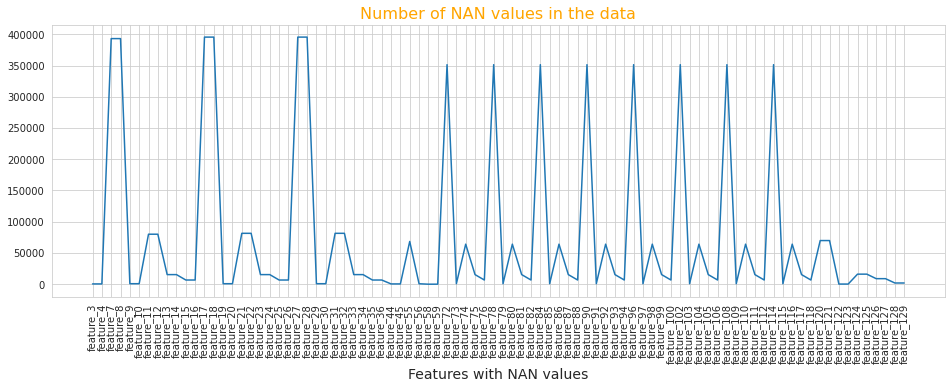

In [ ]:
# number of missing values in each of the features
plt.figure(figsize=(16,5))
null = train_file.isnull().sum()
null = null[null>0]
null.plot()
plt.xticks(np.arange(len(null)), null.index, rotation=90)
plt.xlabel('Features with NAN values', size=14)
plt.title('Number of NAN values in the data', size=16, color='orange')
plt.show()

In [ ]:
null_100 = null[null>=100000].index.to_list()
null_50 =  null[null>=50000].index.to_list()
null_10 =  null[null>=10000].index.to_list()
null_5 =  null[null>=5000].index.to_list()
null_0 =  null[null>0].index.to_list()

null_0 = [c for c in null_0 if c not in null_5]
null_5 = [c for c in null_5 if c not in null_10]
null_10 = [c for c in null_10 if c not in null_50]
null_50 = [c for c in null_50 if c not in null_100]

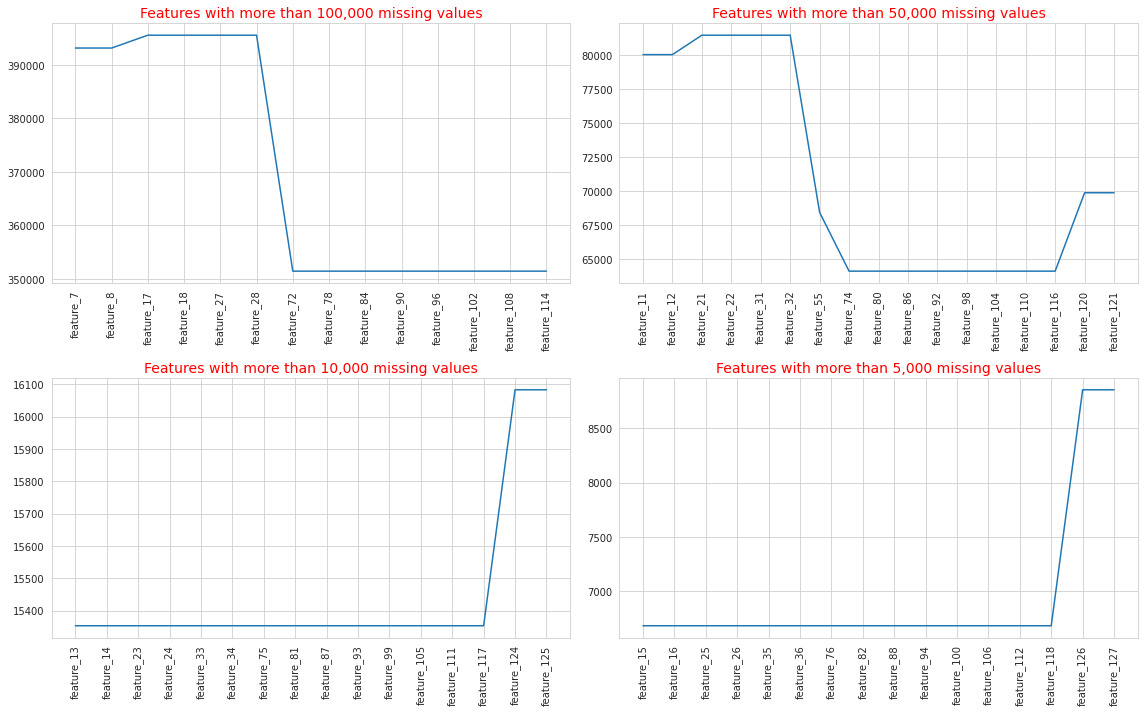

In [ ]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(16,10))
ax1.plot(null[null_100])
ax2.plot(null[null_50])
ax3.plot(null[null_10])
ax4.plot(null[null_5])
ax1.set_title('Features with more than 100,000 missing values',size=14,color='r')
ax2.set_title('Features with more than 50,000 missing values',size=14,color='r')
ax3.set_title('Features with more than 10,000 missing values',size=14,color='r')
ax4.set_title('Features with more than 5,000 missing values',size=14,color='r')
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

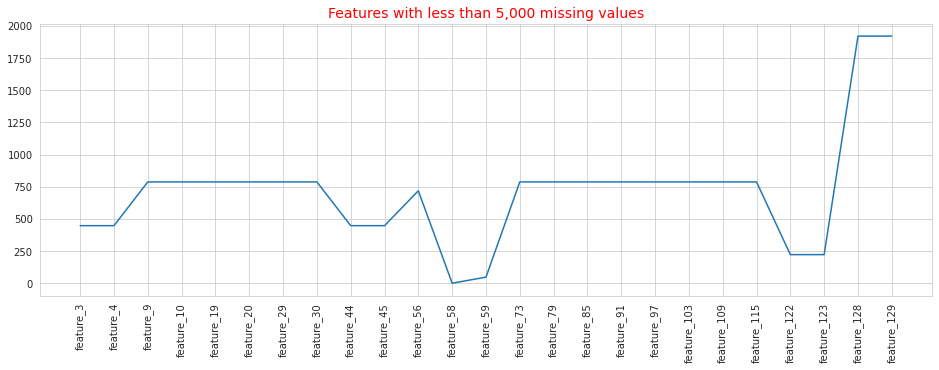

Features with no missing values:  ['feature_0', 'feature_1', 'feature_2', 'feature_5', 'feature_6', 'feature_37', 'feature_38', 'feature_39', 'feature_40', 'feature_41', 'feature_42', 'feature_43', 'feature_46', 'feature_47', 'feature_48', 'feature_49', 'feature_50', 'feature_51', 'feature_52', 'feature_53', 'feature_54', 'feature_57', 'feature_60', 'feature_61', 'feature_62', 'feature_63', 'feature_64', 'feature_65', 'feature_66', 'feature_67', 'feature_68', 'feature_69', 'feature_70', 'feature_71', 'feature_77', 'feature_83', 'feature_89', 'feature_95', 'feature_101', 'feature_107', 'feature_113', 'feature_119']


In [ ]:
plt.figure(figsize=(16,5))
null[null_0].plot()
plt.title('Features with less than 5,000 missing values', size=14, c='r')
plt.xticks(range(len(null_0)), null_0, rotation=90)
plt.show()

features = train_file.columns[train_file.columns.str.contains('feature')]
print("Features with no missing values: ", [c for c in features if c not in null.index])

In [ ]:
# number of days the data has
pd.Series(train_file.date.value_counts())

44     18884
45     15174
459    14603
85     13842
38     13631
       ...  
14      2097
270      663
36       274
2        231
294       29
Name: date, Length: 500, dtype: int64

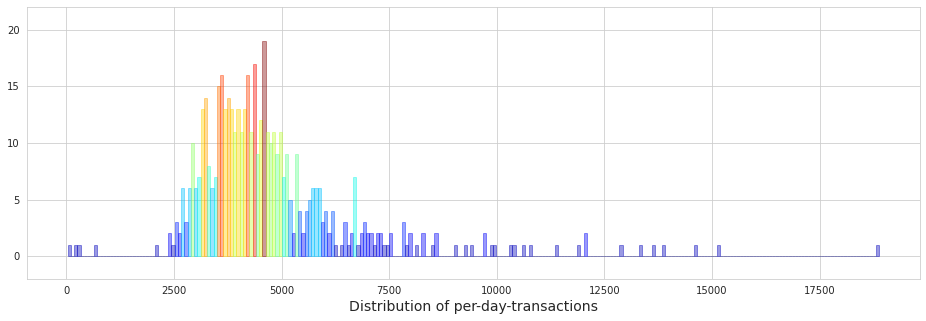

In [ ]:
# distribution plot of transactions occur per day
plt.figure(figsize=(16,5))
ax = sns.distplot(train_file.date.value_counts(), bins=250, kde=False)
heights = np.array([rec.get_height() for rec in ax.patches])
normalizer = plt.Normalize(heights.min(), heights.max())
cmap = plt.cm.jet(normalizer(heights))
for rec, color in zip(ax.patches, cmap):
    rec.set_color(color)
plt.xlabel("Distribution of per-day-transactions", size=14)
plt.ylim([-2,22])
plt.show()

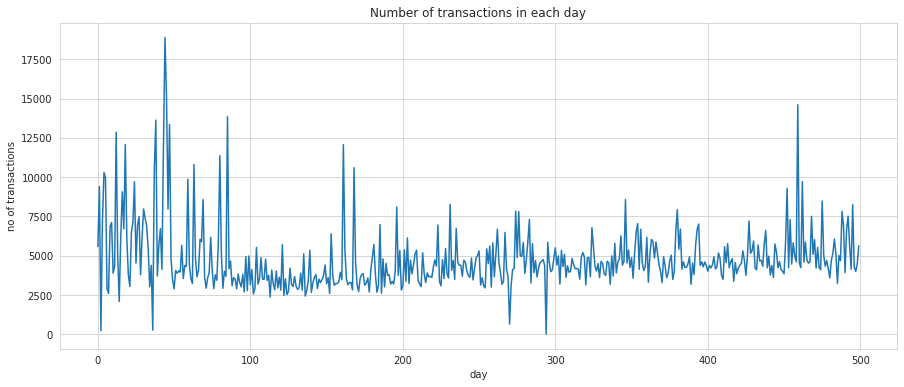

In [ ]:
d = dict(train_file.date.value_counts());

lists = sorted(d.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.figure(figsize=(15,6))
plt.plot(x, y)
plt.title("Number of transactions in each day")
plt.xlabel("day")
plt.ylabel("no of transactions")
plt.show()

#number of 

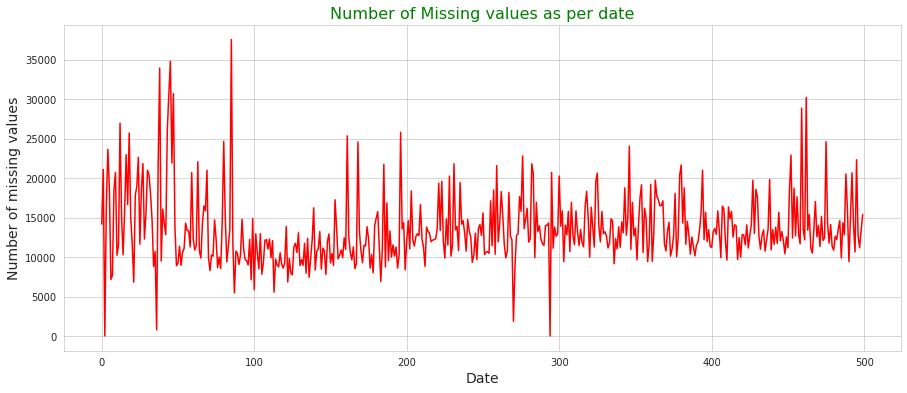

In [ ]:
plt.figure(figsize=(15,6))
(train_file.groupby('date').apply(lambda x: x.isnull().sum()).sum(axis=1)).plot(color='red')
plt.title('Number of Missing values as per date', size=16, color='g')
plt.ylabel('Number of missing values', size=14)
plt.xlabel('Date',size=14)
plt.show()

In [ ]:
train_file.groupby('date').apply(lambda x: x.isnull().sum()).sum(axis=1)

date
0      14174
1      21103
2          0
3      16543
4      23654
       ...  
495    22331
496    12698
497    11187
498    13382
499    15397
Length: 500, dtype: int64

In [ ]:
day_96 = train_file.query('date==96')
day_242 = train_file.query('date==242')
day_454 = train_file.query('date==454')

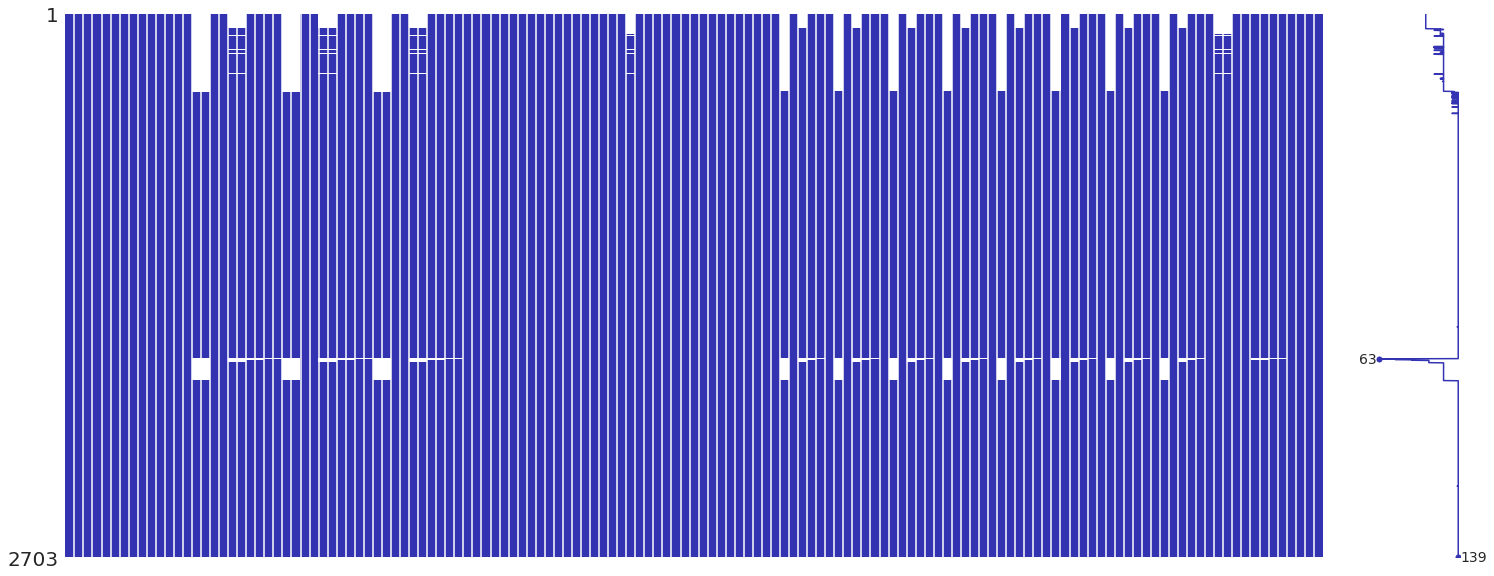

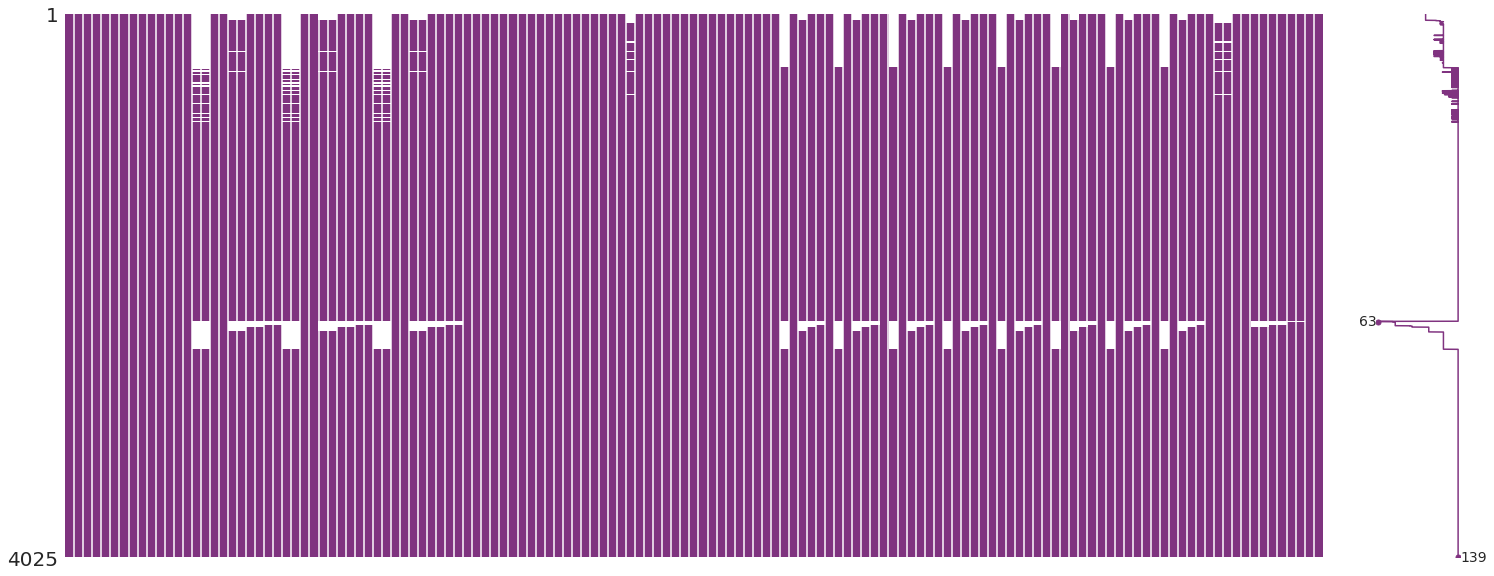

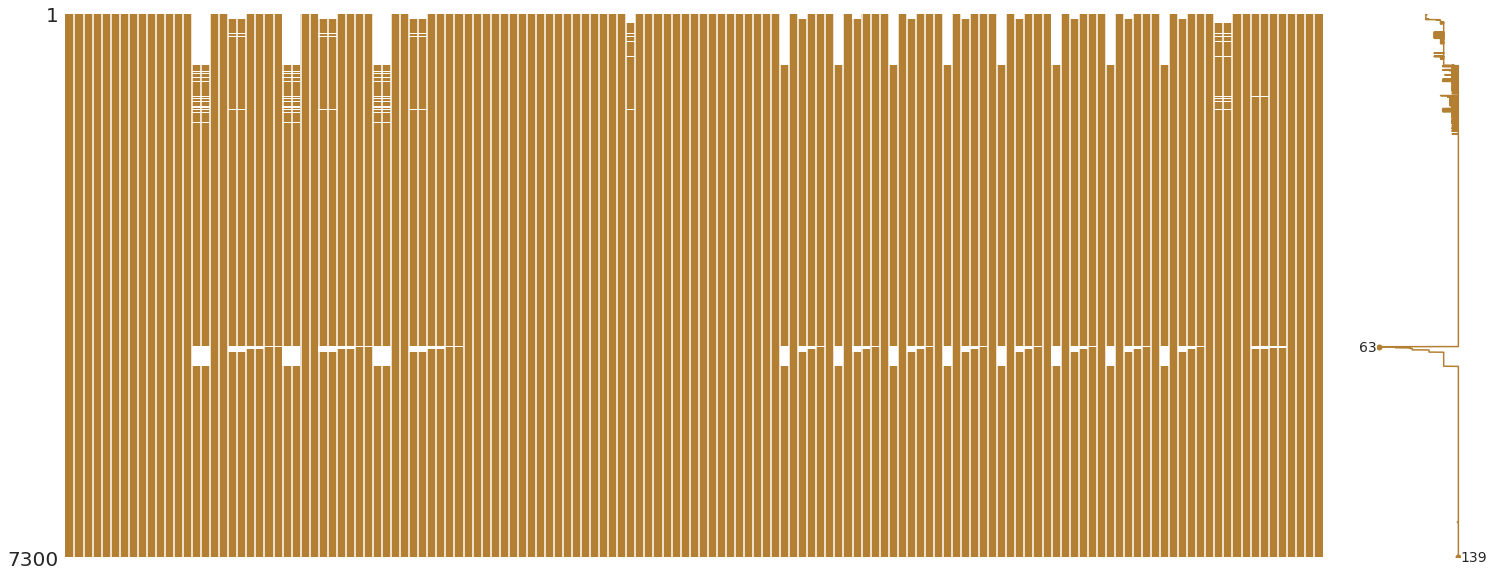

In [ ]:
msno.matrix(day_96,color=(0.2,0.2,0.7))
msno.matrix(day_242,color=(0.5,0.2,0.5))
msno.matrix(day_454,color=(0.7,0.5,0.2))
plt.show()

In [ ]:
# Have a look at data and missing values
pd.options.display.max_columns = None
train_file[null_0][train_file[null_0].isnull().any(axis=1)]

,feature_3,feature_4,feature_9,feature_10,feature_19,feature_20,feature_29,feature_30,feature_44,feature_45,feature_56,feature_58,feature_59,feature_73,feature_79,feature_85,feature_91,feature_97,feature_103,feature_109,feature_115,feature_122,feature_123,feature_128,feature_129
3256,0.679688,0.400146,NaN,NaN,NaN,NaN,NaN,NaN,-1.059570,1.597656,1.826172,-1.476562,0.799316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.290039,0.430664,NaN,NaN
3257,-0.076172,-0.073608,NaN,NaN,NaN,NaN,NaN,NaN,-2.115234,-0.657715,2.257812,-0.987793,1.305664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.930664,2.833984,NaN,NaN
3258,1.822266,1.213867,-4.839844,-2.980469,-2.703125,-2.796875,1.063477,0.815918,-1.474609,-0.121460,1.658203,-1.441406,0.804688,-0.761230,-1.161133,2.882812,7.195312,3.285156,6.503906,3.447266,7.996094,-0.705078,-1.302734,NaN,NaN
3259,0.376709,0.167725,-4.960938,-2.962891,-2.685547,-2.640625,-0.042389,-0.075623,-0.558105,1.211914,12.359375,1.837891,5.718750,-1.598633,-5.937500,-0.304443,-0.021774,2.181641,9.765625,0.958496,7.371094,-1.331055,-0.733887,NaN,NaN
10310,-2.298828,-2.111328,-0.971191,-0.864746,0.386963,0.323730,0.492920,0.489258,-1.462891,-1.057617,NaN,-0.285889,-1.275391,0.021500,0.011147,-1.238281,-1.515625,-1.338867,-0.940430,-3.548828,-2.921875,1.290039,-0.756348,1.37793,-0.804688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2388324,1.457031,2.371094,NaN,NaN,NaN,NaN,NaN,NaN,-0.173218,1.328125,-0.920898,-5.933594,-3.255859,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.966797,-1.641602,NaN,NaN
2388325,1.596680,2.535156,NaN,NaN,NaN,NaN,NaN,NaN,-1.883789,-0.209106,-0.067505,-4.152344,-1.612305,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.235352,1.314453,NaN,NaN
2388326,0.640625,0.888184,NaN,NaN,NaN,NaN,NaN,NaN,-0.144531,-0.086243,1.370117,-1.778320,0.466797,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.005371,2.218750,NaN,NaN
2388327,-0.917969,-1.007812,-2.435547,-1.567383,1.373047,2.251953,-1.066406,-1.870117,-1.163086,-0.486572,0.643555,-2.519531,-0.277100,0.710449,0.416992,1.568359,1.745117,0.830566,0.406738,0.874023,0.885254,0.217163,2.355469,NaN,NaN


In [ ]:
train_file[null_0].describe().T

,count,mean,std,min,25%,50%,75%,max
feature_3,2390043.0,0.008942,0.0,-25.421875,-1.023438,3.159046e-06,1.046875,25.875000
feature_4,2390043.0,0.004162,0.0,-19.125000,-0.979004,0.000000e+00,0.991211,19.421875
feature_9,2389703.0,NaN,0.0,-161.625000,-1.266602,6.437302e-06,1.509766,157.375000
feature_10,2389703.0,NaN,0.0,-106.562500,-0.796875,0.000000e+00,0.975098,91.937500
feature_19,2389703.0,NaN,0.0,-160.375000,-0.737793,-2.980232e-07,1.086914,157.250000
feature_20,2389703.0,NaN,0.0,-92.750000,-0.972168,0.000000e+00,1.317383,90.687500
feature_29,2389703.0,NaN,0.0,-151.125000,-0.735352,0.000000e+00,1.150391,63.500000
feature_30,2389703.0,NaN,0.0,-117.750000,-1.002930,0.000000e+00,1.500000,103.125000
feature_44,2390043.0,NaN,0.0,-7.503906,-1.094727,7.152557e-07,1.268555,77.687500
feature_45,2390043.0,NaN,0.0,-3.164062,-0.565430,0.000000e+00,0.841797,45.812500


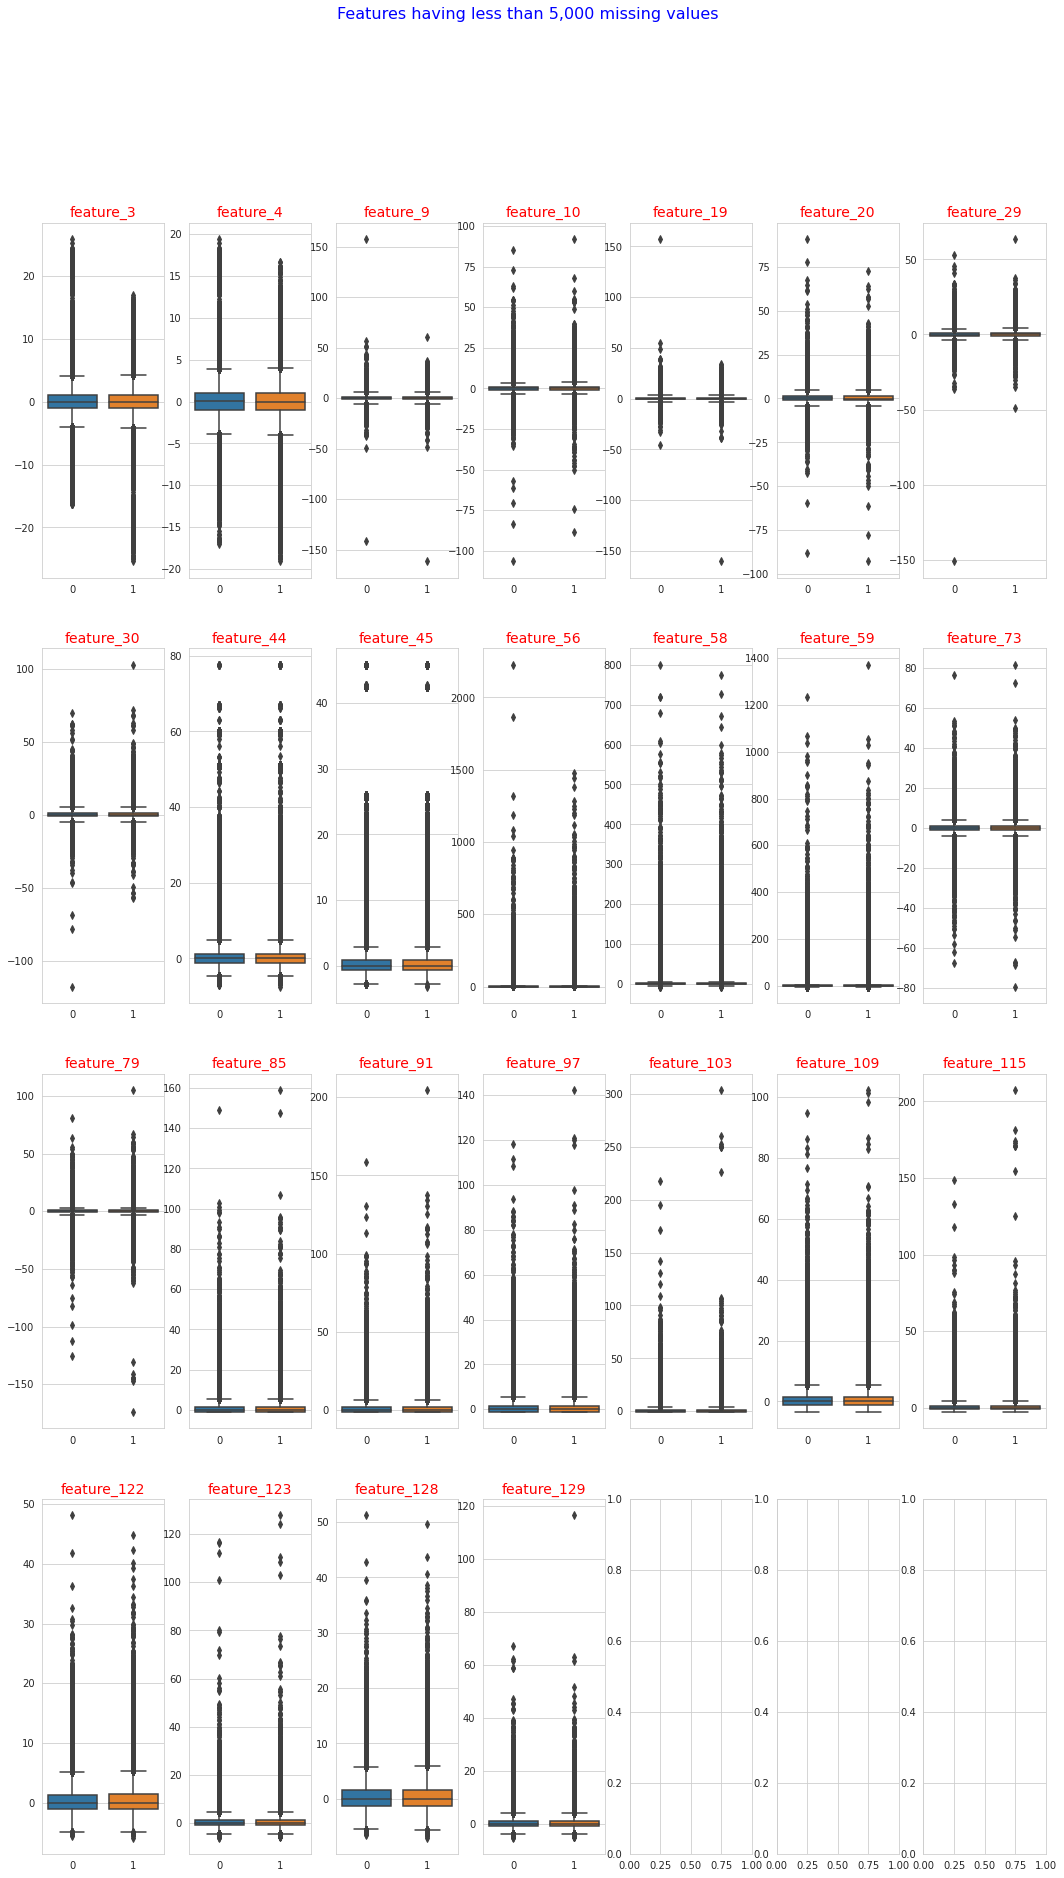

In [ ]:
f, ax = plt.subplots(4,7, figsize=(18,30))
for k,feature in enumerate(null_0):
    i = k//7
    j = k%7
    sns.boxplot(y=feature, x='action', data=train_file, ax = ax[i][j])
    ax[i][j].set_title(str(feature), size=14, color='r')
    ax[i][j].set_ylabel('')
    ax[i][j].set_xlabel('')
plt.suptitle('Features having less than 5,000 missing values', size=16, color='blue')
#plt.tight_layout()
plt.show()

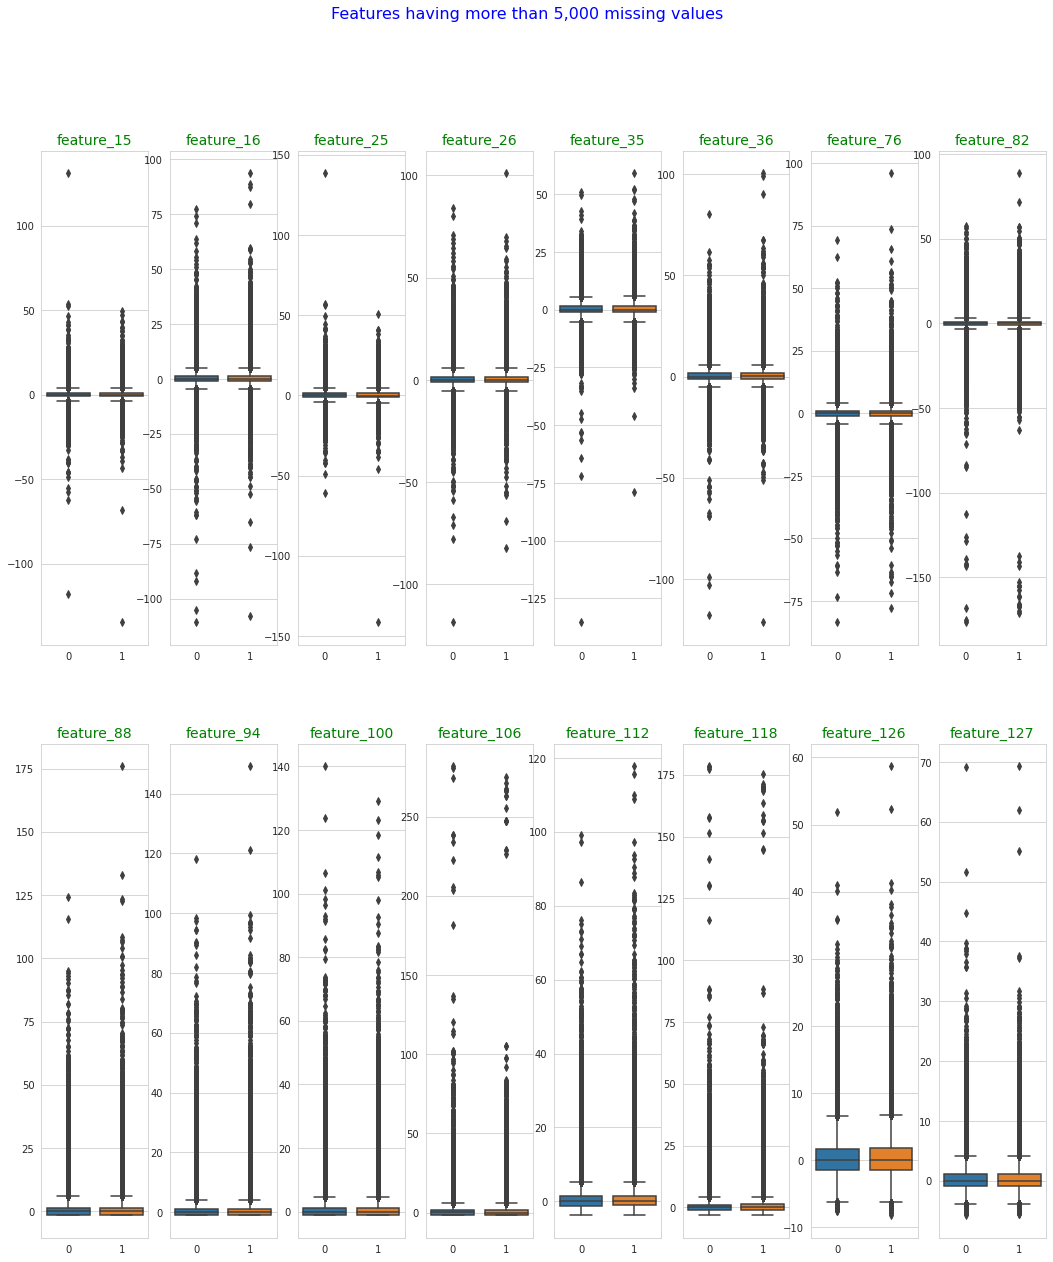

In [ ]:
f, ax = plt.subplots(2,8, figsize=(18,20))
for k,feature in enumerate(null_5):
    i = k//8
    j = k%8
    sns.boxplot(y=feature, x='action', data=train_file, ax = ax[i][j])
    ax[i][j].set_title(str(feature), size=14, color='g')
    ax[i][j].set_ylabel('')
    ax[i][j].set_xlabel('')
plt.suptitle('Features having more than 5,000 missing values', size=16, color='blue')
#plt.tight_layout()
plt.show()

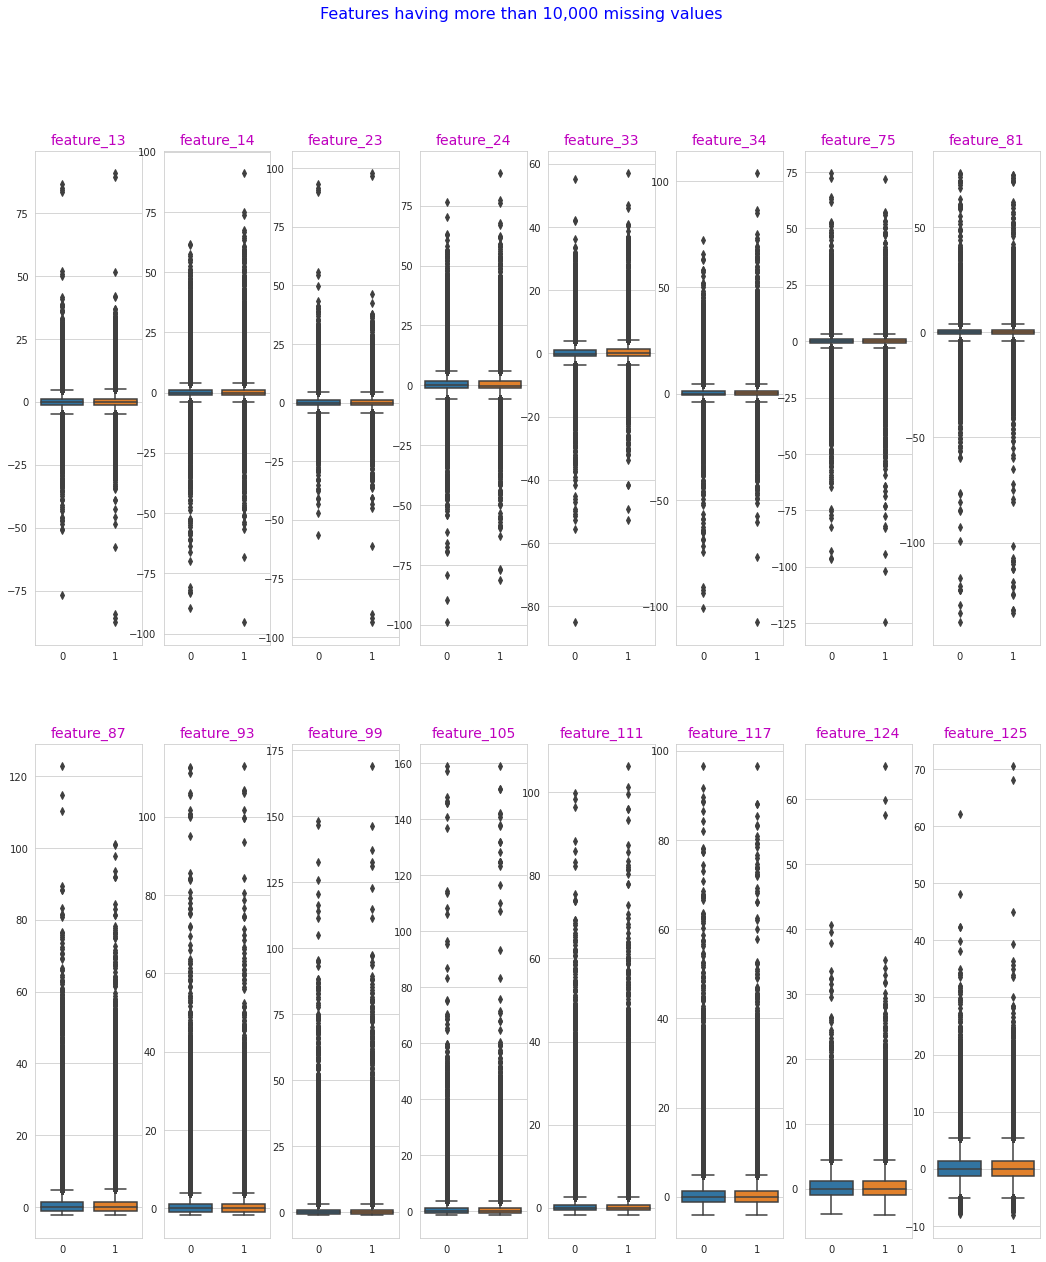

In [ ]:
f, ax = plt.subplots(2,8, figsize=(18,20))
for k,feature in enumerate(null_10):
    i = k//8
    j = k%8
    sns.boxplot(y=feature, x='action', data=train_file, ax = ax[i][j])
    ax[i][j].set_title(str(feature), size=14, color='m')
    ax[i][j].set_ylabel('')
    ax[i][j].set_xlabel('')
plt.suptitle('Features having more than 10,000 missing values', size=16, color='blue')
#plt.tight_layout()
plt.show()

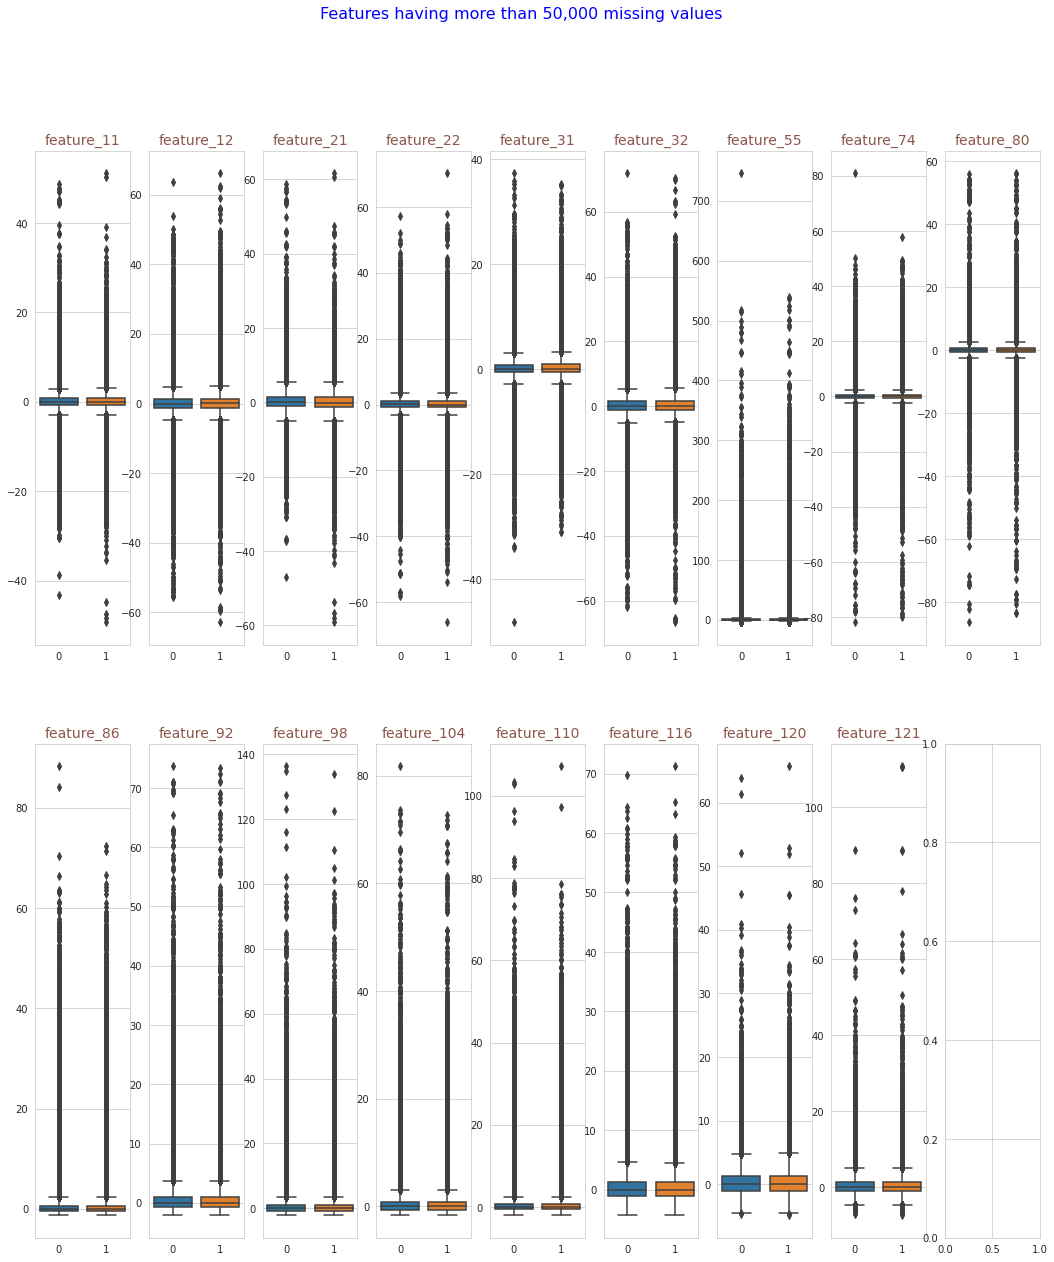

In [ ]:
f, ax = plt.subplots(2,9, figsize=(18,20))
plt.suptitle('Features having more than 50,000 missing values', size=16, color='blue')
for k,feature in enumerate(null_50):
    i = k//9
    j = k%9
    sns.boxplot(y=feature, x='action', data=train_file, ax = ax[i][j])
    ax[i][j].set_title(str(feature), size=14, color='tab:brown')
    ax[i][j].set_ylabel('')
    ax[i][j].set_xlabel('')
#plt.tight_layout()
plt.show()

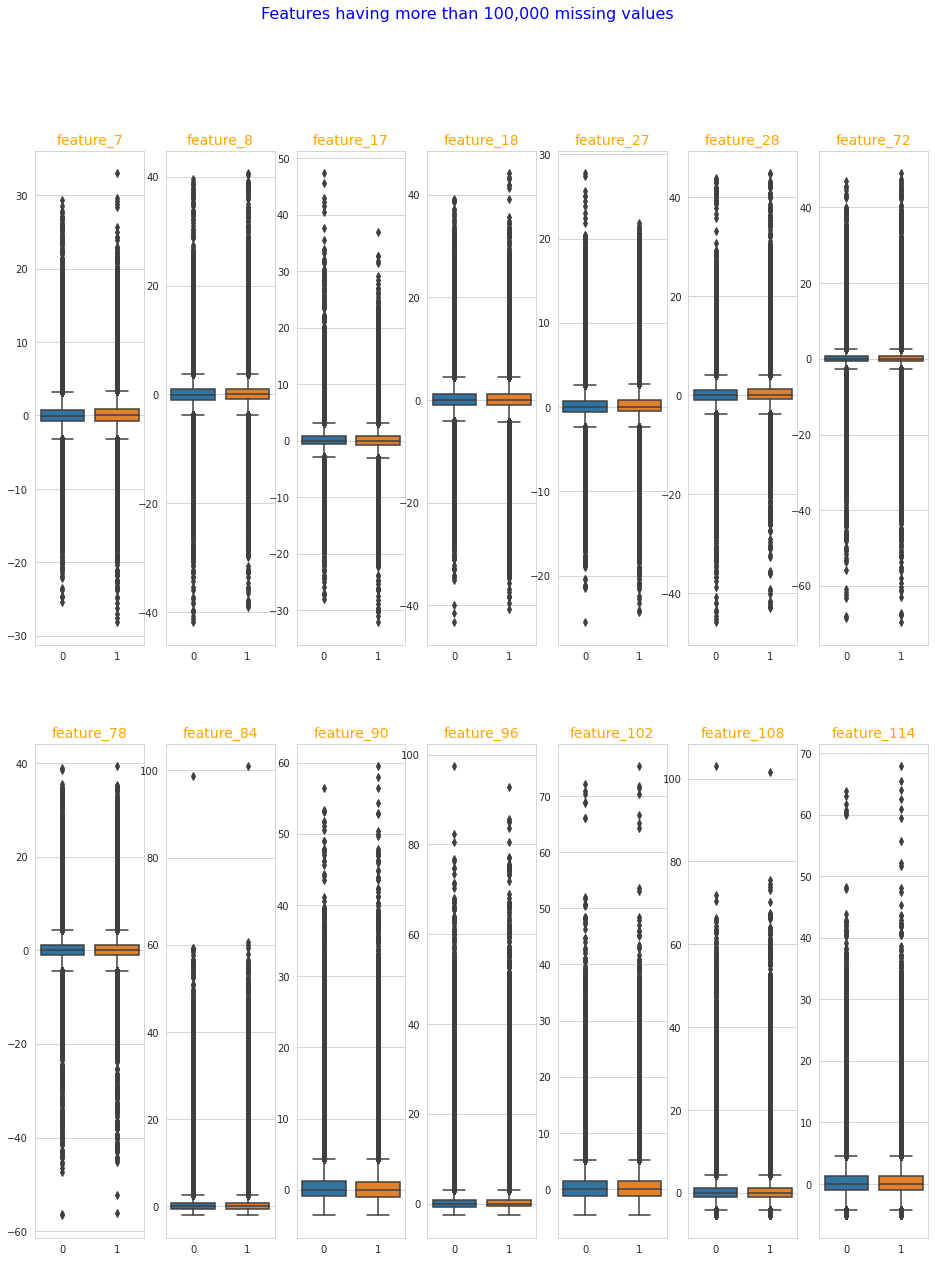

In [ ]:
f, ax = plt.subplots(2,7, figsize=(16,20))
for k,feature in enumerate(null_100):
    i = k//7
    j = k%7
    sns.boxplot(y=feature, x='action', data=train_file, ax = ax[i][j])
    ax[i][j].set_title(str(feature), size=14, color='orange')
    ax[i][j].set_ylabel('')
    ax[i][j].set_xlabel('')
plt.suptitle('Features having more than 100,000 missing values', size=16, color='blue')
#plt.tight_layout()
plt.show()

## Fill in missing values

because of the consistent pattern of missing values in the data, it shouldn't be 


*   filled with mean values or nanmean values
*   filled with any kind of ffill method or something
*   dropped

In [ ]:
print(f'There are {train_file.isnull().sum().sum()} NAN values in the train data')
features = [f'feature_{i}' for i in range(130)]

val_range = train_file[features].max() - train_file[features].min()
filler = pd.Series(train_file[features].min()-0.01*val_range, index=features)
# This filler value will be used as a constant replacement of missing values 

# A function to maintain data type consistency of dataframe
dtype_dict = dict(train_file[features].dtypes)
def consistent_dtype(df):
    return df.astype(dtype_dict)

There are 6762701 NAN values in the train data


In [ ]:
def fill_missing(df):
    df[features] = np.nan_to_num(df[features]) + filler*np.isnan(df[features])
    return df  

In [ ]:
train = fill_missing(train_file)
train = consistent_dtype(train)

assert train.isnull().sum().sum() == 0

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2390491 entries, 0 to 2390490
Columns: 139 entries, date to action
dtypes: float16(135), int16(1), int32(1), int64(1), int8(1)
memory usage: 649.7 MB


## Feature Engineering

In [ ]:
# defining our target
# take the mean of resp, resp_1, resp_2, resp_3, resp_4
# Create target named 'action' which takes value of 1 if the above mean is higher than 0.5, else 0 

y = train[[c for c in train.columns if 'resp' in c]]
y = (y>0)*1
train['action'] = (y.mean(axis=1)>0.5).astype(np.int8)

### Use a segment of the data because the entire data is too large. Here, we use day 242 because of the many opportunities it has per day.

In [ ]:
day_242 = train.query('date==242')

In [ ]:
# Generate Features using Linear shifting, Natural Logarithm and Square Root
for f in [f'feature_{i}' for i in range(1,130)]: # linear shifting to value above 1.0
    day_242['pos_'+str(f)] = (day_242[f]+abs(train[f].min())+1).astype(np.float16)
for f in [f'feature_{i}' for i in range(1,130)]: # Natural log of all the values
    day_242['log_'+str(f)] = np.log(day_242['pos_'+str(f)]).astype(np.float16)
for f in [f'feature_{i}' for i in range(1,130)]: # Square root of all the values
    day_242['sqrt_'+str(f)] = np.sqrt(day_242['pos_'+str(f)]).astype(np.float16)
day_242.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4025 entries, 1144338 to 1148362
Columns: 526 entries, date to sqrt_feature_129
dtypes: float16(522), int16(1), int32(1), int8(2)
memory usage: 4.1 MB


In [ ]:
# Linearly shifted values are used for log and sqrt transformations
# However they are useless since we have our original values which are 100% correlated
# Let's drop them from our data
day_242.drop([f'pos_feature_{i}' for i in range(1,130)], inplace=True, axis=1)
day_242.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4025 entries, 1144338 to 1148362
Columns: 397 entries, date to sqrt_feature_129
dtypes: float16(393), int16(1), int32(1), int8(2)
memory usage: 3.1 MB


In [ ]:
# Find Correlation among features and remove highly correlated features
corr = day_242.corr(method='pearson').abs().unstack().sort_values(kind='quicksort', ascending=False).reset_index()
corr.rename(columns={'level_0':'feature_A', 'level_1':'feature_B', 0:'Corr_Coeff'}, inplace=True)
corr = corr[corr['Corr_Coeff']<=0.8]
corr.dropna(inplace=True)
corr.head()

,feature_A,feature_B,Corr_Coeff
6076,feature_104,feature_117,0.799806
6077,feature_117,feature_104,0.799806
6078,feature_83,log_feature_77,0.799444
6079,log_feature_77,feature_83,0.799444
6080,feature_68,feature_64,0.799397


In [ ]:
# correlattion with the target
corr[corr['feature_A']=='action'].head(10)

,feature_A,feature_B,Corr_Coeff
12024,action,resp_3,0.518632
14058,action,resp,0.475496
15604,action,resp_4,0.452542
21530,action,resp_2,0.376335
25921,action,resp_1,0.326630
57566,action,sqrt_feature_39,0.152233
57601,action,feature_39,0.152055
57652,action,log_feature_39,0.151872
69688,action,feature_3,0.112711
69779,action,sqrt_feature_3,0.112494


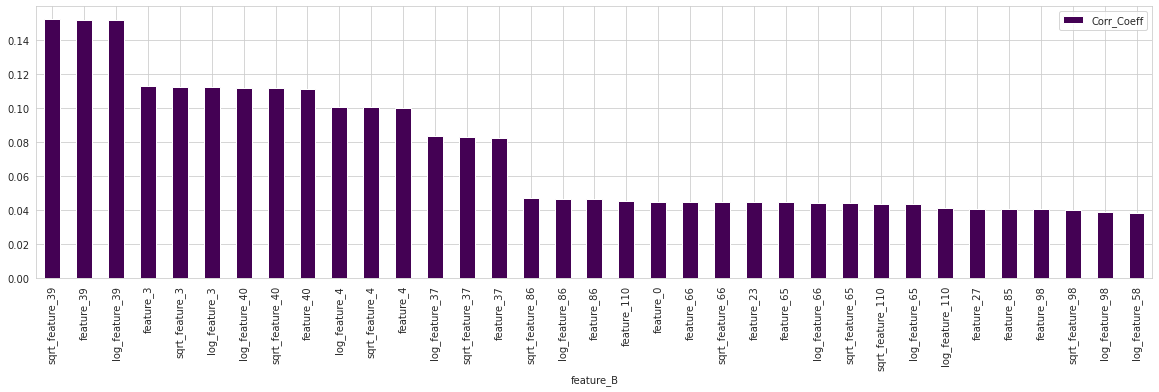

In [ ]:
# Visualize correlation coefficients of features with respect to our target
corr[corr['feature_A']=='action'].iloc[5:40].plot(x='feature_B', y='Corr_Coeff', rot=90, figsize=(20,5), kind='bar', colormap='viridis')
plt.show()

In [ ]:
gen_features = [f for f in day_242.columns if 'feature' in f]
train_X, train_y = day_242[gen_features], day_242['action']
model = RandomForestClassifier(max_features='auto', random_state=SEED).fit(train_X, train_y)

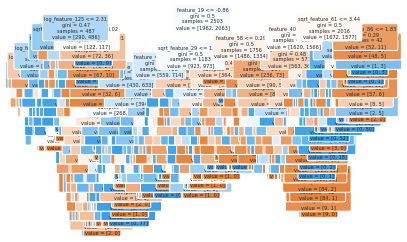

In [ ]:
! dot -c

from IPython.display import SVG

# How does the classification take place in regard of the first tree in Random Forest?
for i in range(2):
    tree.plot_tree(model.estimators_[i], 
                   feature_names=gen_features, 
                   rounded=True, 
                   filled=True, 
                   precision=2,
                   fontsize=5)

In [ ]:
# SHAP values are popular in finding hidden patterns among features
# define an shap value explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_X)

# Initialize Visualization
print('Initializing JavaScript visualization')
shap.initjs() 

Initializing JavaScript visualization


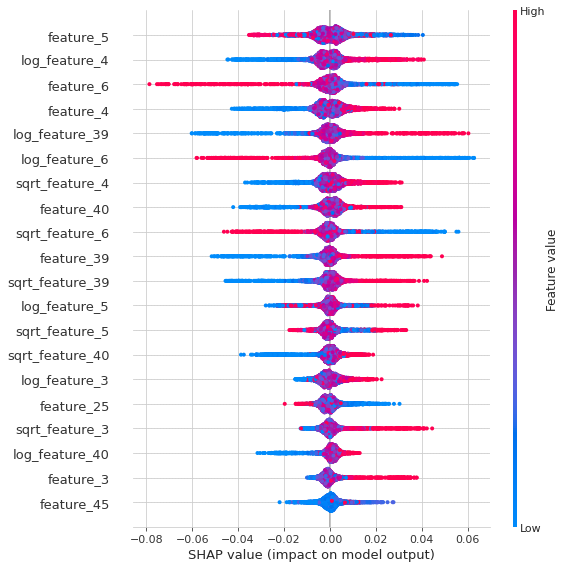

In [ ]:
# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], train_X)

In [ ]:
# adjust nrows, ncols to fit all your columns
fig, axes = plt.subplots(nrows=26, ncols=5, figsize=(21, 80))
axes = axes.ravel()

for i in range(0,129):
    shap.dependence_plot(f'feature_{i+1}', shap_values[1], train_X, ax=axes[i], show=False)
    
plt.suptitle('Features dependence', size=16, color='blue')
fig.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# copy of dataframe 
toy = day_242.copy()

In [ ]:
print(toy.feature_0.value_counts()) # feature_0 is a categorical variable

# Make it OneHot
toy['feature_0']=((toy['feature_0']+1)/2).astype(np.int8)
print("\nAfter One Hot encoing, ...\n", toy.feature_0.value_counts())

 1    2056
-1    1969
Name: feature_0, dtype: int64

After One Hot encoing, ...
 1    2056
0    1969
Name: feature_0, dtype: int64


In [ ]:
# From the Shap Dependence plots above, the following features seem to have cubic relationship with target
cubic = [3, 4, 5, 6, 28, 39, 128]
for i in cubic:
    f = f'feature_{i}'
    threes = np.full((len(toy[f])), 3)
    toy['cube_'+f] =np.power(toy[f], threes) 

# the following features seem to have quadratic relationship with target
quad = [3, 4, 5, 6, 8, 13, 17, 19, 23, 26, 27, 28, 32, 37, 39, 40, 41, 44, 45, 53, 54, 55, 57, 60, 61, 77, 83, 121, 124, 125, 127, 128]
for i in quad:
    f = f'feature_{i}'
    toy['quad_'+f] =np.square(toy[f]) 

In [ ]:
# Test the correlation of newly generated features with respect to target 
new = toy.corr(method='pearson').abs().unstack().sort_values(kind='quicksort', ascending=False).reset_index()
new.rename(columns={0:'coeff'}, inplace=True)
new = new[new['coeff']<0.8]
new.dropna(inplace=True)

In [ ]:
# Test cubic features
new[new['level_0'].str.contains('action')][new['level_1'].str.contains('cube')].head()

,level_0,level_1,coeff
80474,action,cube_feature_39,0.113542
113152,action,cube_feature_4,0.061269
113279,action,cube_feature_3,0.061110
121626,action,cube_feature_6,0.050527
158937,action,cube_feature_28,0.019139


In [ ]:
# Test quadratic features
new[new['level_0'].str.contains('action')][new['level_1'].str.contains('quad')].head()


,level_0,level_1,coeff
133858,action,quad_feature_60,0.039035
134884,action,quad_feature_61,0.038224
146289,action,quad_feature_121,0.028976
150062,action,quad_feature_23,0.025937
150119,action,quad_feature_13,0.025889


In [ ]:
# Test a random feature
new[new['level_0'].str.contains('action')][new['level_1'].str.contains('67')].head(6)

,level_0,level_1,coeff
186829,action,log_feature_67,0.001350
187730,action,sqrt_feature_67,0.000837
189080,action,feature_67,0.000079


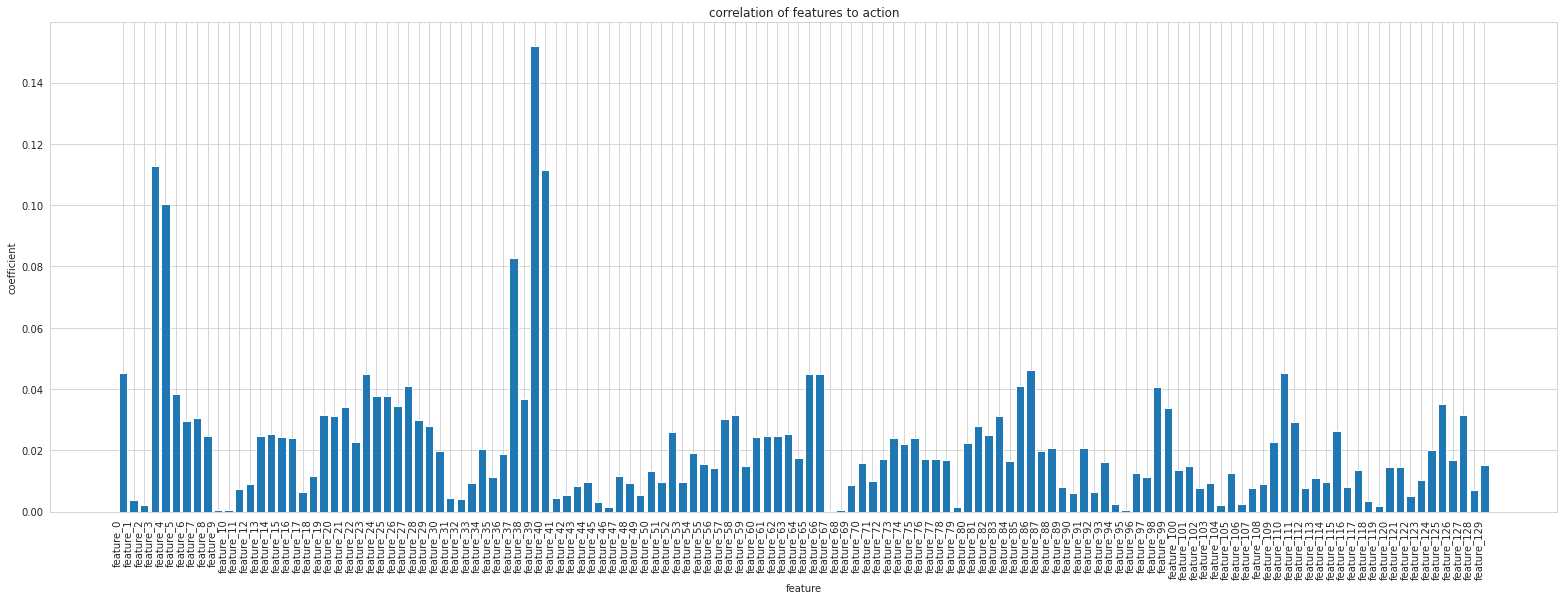

In [ ]:
toyz = toy.corr(method='pearson').abs().unstack().reset_index()
toyz.rename(columns={0:'coeff'}, inplace=True)
toyz = toyz[toyz['coeff']<0.8]
toyz.dropna(inplace=True)
toyz = toyz[toyz["level_0"].str.contains("action")][toyz["level_1"].str.startswith("feature")]

plt.figure(figsize=(27, 9))
plt.bar(toyz["level_1"], toyz["coeff"])
plt.title("correlation of features to action")
plt.xlabel("feature")
plt.ylabel("coefficient")
plt.setp(plt.gca().get_xticklabels(), rotation=90, ha="right")
plt.show()

In [ ]:
toyz

,level_0,level_1,coeff
60175,action,feature_0,0.045071
60176,action,feature_1,0.003788
60177,action,feature_2,0.002290
60178,action,feature_3,0.112711
60179,action,feature_4,0.100352
...,...,...,...
60300,action,feature_125,0.035191
60301,action,feature_126,0.016769
60302,action,feature_127,0.031450
60303,action,feature_128,0.007106


In [ ]:
# features that can be added together or subtracted
add_pairs = [(6,4), (13,66),(23,66),(32,61),(37,45),(40,45),(54,45),(81,66),(111,112)]
for i,j in add_pairs:
    toy[f'add_{i}_{j}'] = toy[f'feature_{i}']+toy[f'feature_{j}'] 
    toy[f'sub_{i}_{j}'] = toy[f'feature_{i}']-toy[f'feature_{j}']

add_log_pairs = [(4,6), (5,42),(9,97),(16,87),(17,42),(21,105),(28,95),(33,42),(46,69),(73,25),(95,126),(128,126)]
for i,j in add_log_pairs:
    toy[f'add_{i}_log{j}'] = toy[f'feature_{i}']+toy[f'log_feature_{j}']
    toy[f'sub_{i}_log{j}'] = toy[f'feature_{i}']-toy[f'log_feature_{j}']

In [ ]:
# features that can be multiplied together
mul_pairs = [(13,66), (19,95), (23,66), (27,92), (32,61),(38,42),(61,19)]
for i,j in mul_pairs:
    toy[f'mul_{i}_{j}'] = toy[f'feature_{i}']*toy[f'feature_{j}']

mul_log_pairs = [(5,42), (17,42), (21,105), (26,105), (33,42), (47,102)]
for i,j in mul_log_pairs:
    toy[f'mul_{i}_log{j}'] = toy[f'feature_{i}']*toy[f'log_feature_{j}']

In [ ]:
# Test the correlation of newly generated features with respect to target 
n = toy.corr(method='pearson').abs().unstack().sort_values(kind='quicksort', ascending=False).reset_index()
n.rename(columns={0:'coeff'}, inplace=True)
n = n[n['coeff']<0.9]
n.dropna(inplace=True)

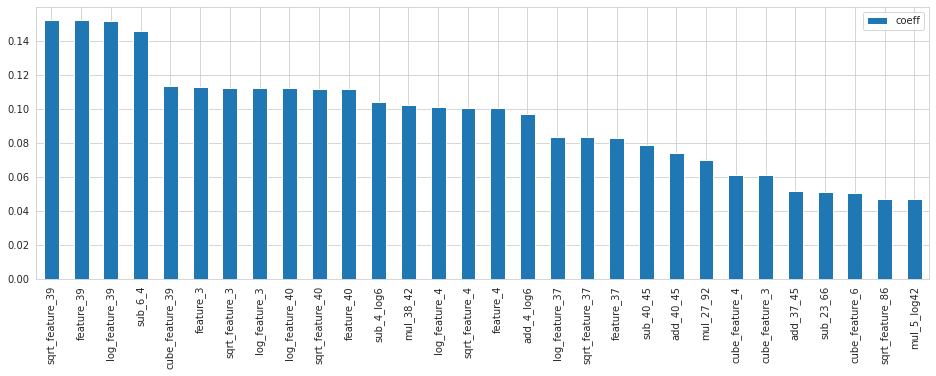

In [ ]:
# Test latest features by plotting their correlation
corr_action = n[n['level_0']=='action'].iloc[5:35, :].reset_index()
ax = corr_action.plot(y='coeff', kind='bar', xticks=np.arange(30), rot=90, figsize=(16,5))
ax.set_xticklabels(corr_action['level_1'])
plt.show()

In [ ]:
def feature_transforms(df):
    # Generate Features using Linear shifting, Natural Logarithm and Square Root
    for f in [f'feature_{i}' for i in range(1,130)]: 
        # linear shifting to value above 1.0
        df['pos_'+str(f)] = (df[f]+abs(train[f].min())+1).astype(np.float16)
    for f in [f'feature_{i}' for i in range(1,130)]: 
        # Natural log of all the values
        df['log_'+str(f)] = np.log(df['pos_'+str(f)]).astype(np.float16)
    for f in [f'feature_{i}' for i in range(1,130)]: 
        # Square root of all the values
        df['sqrt_'+str(f)] = np.sqrt(df['pos_'+str(f)]).astype(np.float16)
    
    # Linearly shifted values are used for log and sqrt transformations
    # However they are useless since we have our original values which are 100% correlated
    # Let's drop them from our data
    df.drop([f'pos_feature_{i}' for i in range(1,130)], inplace=True, axis=1)
    
    # From the Shap Dependence plots, the following features seem to have cubic relationship with target
    cubic = [3, 4, 5, 6, 28, 39, 128]
    for i in cubic:
        f = f'feature_{i}'
        threes = np.full((len(df[f])), 3)
        df['cub_'+f] =np.power(df[f], threes) 
        
    # From the Shap Dependence plots, the following features seem to have quadratic relationship with target
    quad = [3, 4, 5, 6, 8, 13, 17, 19, 23, 26, 27, 28, 32, 37, 39, 40, 41, 44, 45, 53, 54, 55, 57, 60, 61, 77, 83, 121, 124, 125, 127, 128]
    for i in quad:
        f = f'feature_{i}'
        df['quad_'+f] =np.square(df[f]) 
    
    return df

def manipulate_pairs(df):
    # features that can be added together or subtracted
    add_pairs = [(6,4), (13,66),(23,66),(32,61),(37,45),(40,45),(54,45),(81,66),(111,112)]
    for i,j in add_pairs:
        df[f'add_{i}_{j}'] = df[f'feature_{i}']+df[f'feature_{j}']
        df[f'sub_{i}_{j}'] = df[f'feature_{i}']-df[f'feature_{j}']

    add_log_pairs = [(4,6), (5,42),(9,97),(16,87),(17,42),(21,105),(28,95),(33,42),(46,69),(73,25),(95,126),(128,126)]
    for i,j in add_log_pairs:
        df[f'add_{i}_log{j}'] = df[f'feature_{i}']+df[f'log_feature_{j}']
        df[f'sub_{i}_log{j}'] = df[f'feature_{i}']-df[f'log_feature_{j}']
    # features that can be multiplied together
    mul_pairs = [(13,66), (19,95), (23,66), (27,92), (32,61),(38,42),(61,19)]
    for i,j in mul_pairs:
        df[f'mul_{i}_{j}'] = df[f'feature_{i}']*df[f'feature_{j}']

    mul_log_pairs = [(5,42), (17,42), (21,105), (26,105), (33,42), (47,102)]
    for i,j in mul_log_pairs:
        df[f'mul_{i}_log{j}'] = df[f'feature_{i}']*df[f'log_feature_{j}']
    return df

In [ ]:
# Obtain data from day 201 to 300
df = train.query('weight > 0')
df = df.query('date>200') 
df = df.query('date<=300')

In [ ]:
df = feature_transforms(df)
df = manipulate_pairs(df)

In [ ]:
# Number of features we have now
latest_features = df.columns.drop(['action','resp','resp_1','resp_2','resp_3','resp_4'])
len(latest_features)

485

In [ ]:
# Feature selection
# Select 100 features (100 is random, can be varied)
selector = SelectKBest(f_classif, k=35)
temp = selector.fit_transform(df[latest_features], df['action'])
df_new = pd.DataFrame(selector.inverse_transform(temp), index=df.index, columns=latest_features)
selected_features = df_new.columns[df_new.var() != 0]
print(selected_features)

## Training
